<a id='top-page'></a>
# Building a reduced-order model (ROM) using a QoI-aware encoder-decoder projection of a zero-dimensional reactor

### Table of contents

- [**Load the training data**](#load-data)
- [**Generate a low-dimensional projection**](#generate-projection)
- [**Build a deep neural network (DNN) model**](#DNN)
- [**Evolve the reduced-order model (ROM)**](#ROM)
- [**Reconstruct the thermo-chemical state-space variables**](#reconstruct-state-space)
- [**Visualize the predicted $H_2O$ mass fraction profile**](#visualize-reconstruction)

***

In [1]:
%run -i imports.py
%matplotlib inline

In [2]:
plot_save_location = '../figures/'
color_dnn = '#1c8aa9'
cmap = cmc.lajolla

<a id='load-data'></a>
***

## Load the training data

[Go to the top ↑](#top-page)

In [3]:
data_path = '../data/'
data_tag = 'CO-H2-10-1-isobaric-adiabatic-closed-HR'
species_to_remove_list = ['N2']

state_space_names = pd.read_csv(data_path + data_tag + '-state-space-names.csv', sep = ',', header=None).to_numpy().ravel()
state_space = pd.read_csv(data_path + data_tag + '-state-space.csv', sep = ',', header=None).to_numpy()
state_space_sources = pd.read_csv(data_path + data_tag + '-state-space-sources.csv', sep = ',', header=None).to_numpy()
mixture_fraction = pd.read_csv(data_path + data_tag + '-mixture-fraction.csv', sep = ',', header=None).to_numpy()
time_grid = pd.read_csv(data_path + data_tag + '-time.csv', sep = ',', header=None).to_numpy().ravel()

state_space_test_trajectory = pd.read_csv(data_path + data_tag + '-state-space-test-trajectory.csv', sep = ',', header=None).to_numpy()
state_space_sources_test_trajectory = pd.read_csv(data_path + data_tag + '-state-space-sources-test-trajectory.csv', sep = ',', header=None).to_numpy()
time_grid_test_trajectory = pd.read_csv(data_path + data_tag + '-time-test-trajectory.csv', sep = ',', header=None).to_numpy().ravel()

for species_to_remove in species_to_remove_list:

    (species_index, ) = np.where(state_space_names==species_to_remove)
    if len(species_index) != 0:
        print('Removing ' + state_space_names[int(species_index)] + '.')
        state_space = np.delete(state_space, np.s_[species_index], axis=1)
        state_space_sources = np.delete(state_space_sources, np.s_[species_index], axis=1)
        
        state_space_test_trajectory = np.delete(state_space_test_trajectory, np.s_[species_index], axis=1)
        state_space_sources_test_trajectory = np.delete(state_space_sources_test_trajectory, np.s_[species_index], axis=1)
        
        state_space_names = np.delete(state_space_names, np.s_[species_index])
    else:
        print(species_to_remove + ' already removed from the data set.')

(n_observations, n_variables) = np.shape(state_space)

print('\nThe data set has ' + str(n_observations) + ' observations.')

Removing N2.

The data set has 68140 observations.


<a id='generate-projection'></a>
***

## Generate a low-dimensional projection

[Go to the top ↑](#top-page)

In [4]:
random_seed = 10
n_components = 2
learning_rate = 0.001
n_epochs = 3000
decoder_interior_architecture = (7,10,11)
activation_decoder = 'tanh'
batch_size = n_observations
transformed_projection_dependent_outputs = 'signed-square-root'
loss = 'MSE'
optimizer = 'Adam'
validation_perc = 10
target_variables_indices = [0, 1, 2, 4, 5, 8, 9]

In [5]:
target_variables_names = list(state_space_names[target_variables_indices])
print('\nUsing: ' + ', '.join(target_variables_names) + ' as target variables.')


Using: T, H2, O2, OH, H2O, CO, CO2 as target variables.


In [6]:
(X_CS, centers, scales) = preprocess.center_scale(state_space, scaling='-1to1')
S_CS = state_space_sources / scales

state_space_test_trajectory_CS = (state_space_test_trajectory - centers) / scales
state_space_sources_test_trajectory_CS = state_space_sources_test_trajectory / scales

In [7]:
projection = QoIAwareProjection(X_CS,
                               n_components,
                               projection_independent_outputs=X_CS[:,target_variables_indices],
                               projection_dependent_outputs=S_CS,
                               activation_decoder=activation_decoder,
                               decoder_interior_architecture=decoder_interior_architecture,
                               encoder_weights_init=None,
                               decoder_weights_init=None,
                               hold_initialization=None,
                               hold_weights=None,
                               transformed_projection_dependent_outputs=transformed_projection_dependent_outputs,
                               loss=loss,
                               optimizer=optimizer,
                               batch_size=batch_size,
                               n_epochs=n_epochs,
                               learning_rate=learning_rate,
                               validation_perc=validation_perc,
                               random_seed=random_seed,
                               verbose=True)

In [8]:
projection.summary()

QoI-aware encoder-decoder model summary...

(Model has not been trained yet)


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Projection dimensionality:

	- 2D projection

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Encoder-decoder architecture:

	11-2-7-10-11-11

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Activation functions:

	(11)--linear--(2)--tanh--(7)--tanh--(10)--tanh--(11)--tanh--(11)

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Variables at the decoder output:

	- 7 projection independent variables
	- 2 projection dependent variables
	- 2 transformed projection dependent variables using signed-square-root

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

In [9]:
projection.train()

Starting model training...


Decoder outputs are scaled to a -1 to 1 range.
Using 10% of input data as validation data. Model will be trained on 90% of input data.



  0%|                                                  | 0/3000 [00:00<?, ?it/s]/Users/kamilazdybal/anaconda3/envs/latest-stack/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
100%|███████████████████████████████████████| 3000/3000 [03:04<00:00, 16.26it/s]

Time it took: 3.1 minutes.



<module 'matplotlib.pyplot' from '/Users/kamilazdybal/anaconda3/envs/latest-stack/lib/python3.10/site-packages/matplotlib/pyplot.py'>

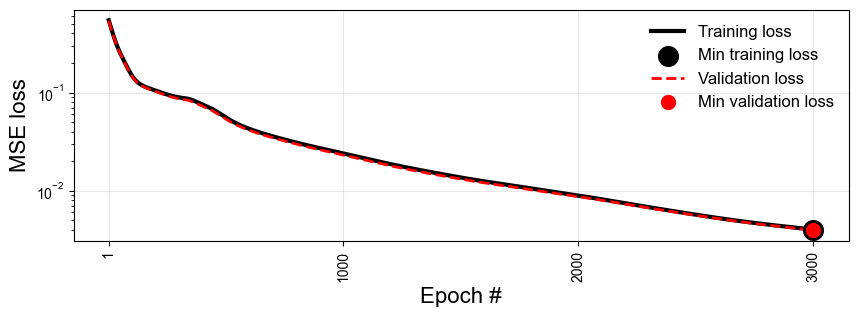

In [10]:
projection.plot_losses(markevery=1000, figure_size=(10,3))

In [11]:
basis = projection.get_best_basis(method='min-training-loss')

Minimum training loss:		0.004011865239590406
Minimum training loss at epoch:	3000


In [12]:
X_QoIAwareProjection = np.dot(X_CS, basis)
S_QoIAwareProjection = np.dot(S_CS, basis)

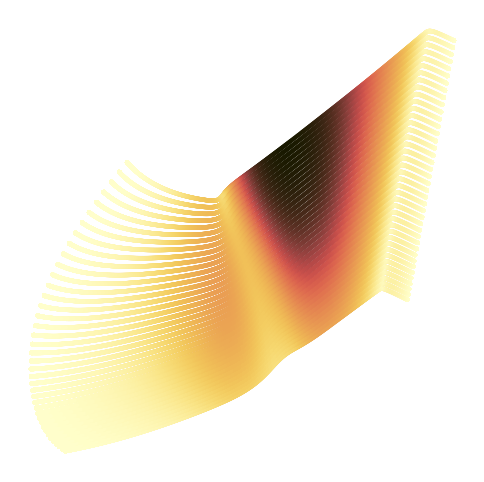

In [13]:
reduction.plot_2d_manifold(X_QoIAwareProjection[:,0],
                           X_QoIAwareProjection[:,1],
                           clean=True,
                           color=S_QoIAwareProjection[:,0],
                           s=10,
                           color_map=cmap,
                           figure_size=(6,6));

In [14]:
X_QoIAwareProjection_CS, center_X_QoIAwareProjection, scale_X_QoIAwareProjection = preprocess.center_scale(X_QoIAwareProjection, scaling='-1to1')
S_QoIAwareProjection_CS, center_S_QoIAwareProjection, scale_S_QoIAwareProjection = preprocess.center_scale(S_QoIAwareProjection, scaling='-1to1')

X_QoIAwareProjection_test_trajectory = np.dot(state_space_test_trajectory_CS, basis)
X_QoIAwareProjection_test_trajectory_CS = (X_QoIAwareProjection_test_trajectory - center_X_QoIAwareProjection) / scale_X_QoIAwareProjection
S_QoIAwareProjection_test_trajectory = np.dot(state_space_sources_test_trajectory_CS, basis)

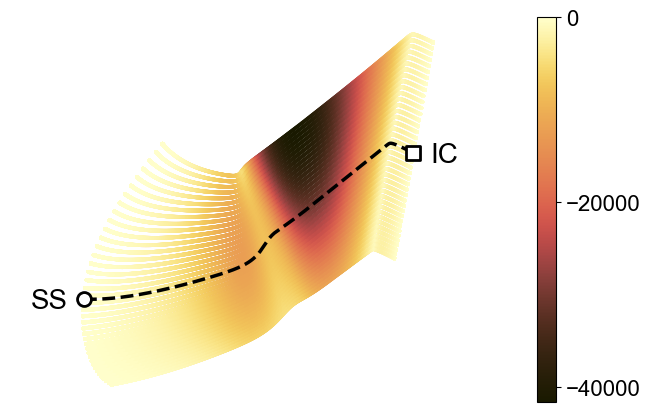

In [15]:
plt.figure(figsize=(8,5))
plt.plot(X_QoIAwareProjection_test_trajectory_CS[:,0], X_QoIAwareProjection_test_trajectory_CS[:,1], 'k--', label='Test trajectory', zorder=30, lw=2.5)
scat = plt.scatter(X_QoIAwareProjection_CS[:,0], X_QoIAwareProjection_CS[:,1], c=S_QoIAwareProjection[:,0], s=3, cmap=cmap, zorder=20)

plt.scatter(X_QoIAwareProjection_test_trajectory_CS[0,0], X_QoIAwareProjection_test_trajectory_CS[0,1], c='w', edgecolors='k', marker='s', s=100, lw=2, zorder=100)
plt.scatter(X_QoIAwareProjection_test_trajectory_CS[-1,0], X_QoIAwareProjection_test_trajectory_CS[-1,1], c='w', edgecolors='k', marker='o', s=100, lw=2, zorder=100)
plt.text(X_QoIAwareProjection_test_trajectory_CS[0,0]+0.1, X_QoIAwareProjection_test_trajectory_CS[0,1]-0.05, 'IC', fontsize=20)
plt.text(X_QoIAwareProjection_test_trajectory_CS[-1,0]-0.3, X_QoIAwareProjection_test_trajectory_CS[-1,1]-0.05, 'SS', fontsize=20)
plt.axis('equal')
plt.grid(alpha=0.3, zorder=1)
plt.xticks([])
plt.yticks([])
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
cbar = plt.colorbar(scat, ticks=[-40000, -20000, 0], aspect=20)
for t in cbar.ax.get_yticklabels():
    t.set_fontproperties('Arial')
    t.set_fontsize(16)
plt.savefig(plot_save_location + 'QoIAwareProjection-2D-projection.png', dpi=400, bbox_inches='tight')

<a id='DNN'></a>
***

## Build a deep neural network (DNN) model

[Go to the top ↑](#top-page)

In [16]:
dnn_model = ANN(X_QoIAwareProjection_CS,
                S_QoIAwareProjection_CS,
                interior_architecture=(5,10,15,10,5),
                activation_functions='tanh',
                weights_init='glorot_uniform',
                biases_init='zeros',
                loss='MSE',
                optimizer='Adam',
                batch_size=100,
                n_epochs=1500,
                learning_rate=0.001,
                validation_perc=10,
                random_seed=100,
                verbose=True)

In [17]:
dnn_model.summary()

ANN model summary...

(Model has not been trained yet)


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
ANN architecture:

	2-5-10-15-10-5-2

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Activation functions:

	(2)--tanh--(5)--tanh--(10)--tanh--(15)--tanh--(10)--tanh--(5)--tanh--(2)

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Model validation:

	- Using 10% of input data as validation data
	- Model will be trained on 90% of input data

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Hyperparameters:

	- Batch size:		100
	- # of epochs:		1500
	- Optimizer:		Adam
	- Learning rate:	0.001
	- Loss function:	MSE

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

In [18]:
dnn_model.train()

Starting model training...


Using 10% of input data as validation data. Model will be trained on 90% of input data.



100%|███████████████████████████████████████| 1500/1500 [12:03<00:00,  2.07it/s]

Time it took: 12.1 minutes.



<module 'matplotlib.pyplot' from '/Users/kamilazdybal/anaconda3/envs/latest-stack/lib/python3.10/site-packages/matplotlib/pyplot.py'>

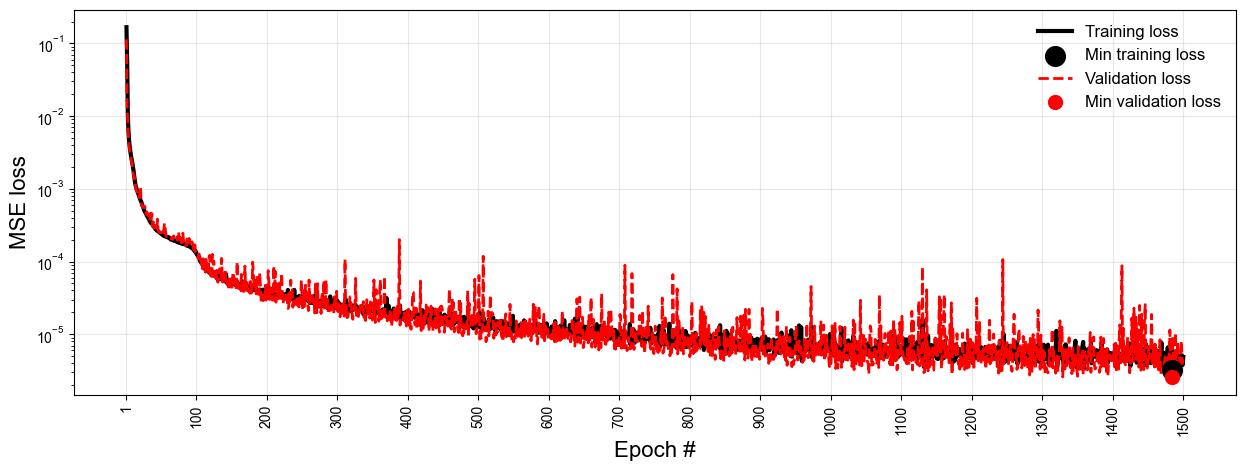

In [19]:
dnn_model.plot_losses()

In [20]:
S_predicted_ann = dnn_model.predict(X_QoIAwareProjection_test_trajectory_CS)
S_predicted_ann = preprocess.invert_center_scale(S_predicted_ann, center_S_QoIAwareProjection, scale_S_QoIAwareProjection)

/Users/kamilazdybal/anaconda3/envs/latest-stack/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [21]:
ANN_metrics = reconstruction.RegressionAssessment(S_QoIAwareProjection_test_trajectory, S_predicted_ann, variable_names=['$S_{\eta, 1}$', '$S_{\eta, 2}$'])
ANN_metrics.print_metrics(table_format=['pandas'], float_format='.8f', metrics=['R2', 'MSLE', 'NRMSE', 'GDE'])

,R2,MSLE,NRMSE,GDE
"$S_{\eta, 1}$",0.99996935,1.39369062,0.00553641,97.54985755
"$S_{\eta, 2}$",0.99997028,0.37448518,0.00545186,97.54985755


<a id='ROM'></a>

***

## Evolve the reduced-order model (ROM)

[Go to the top ↑](#top-page)

#### Initial condition in the low-dimensional space:

In [22]:
start_simulation = 140
initial_condition = X_QoIAwareProjection_test_trajectory[start_simulation,:]

In [23]:
t_coordinates = time_grid_test_trajectory[start_simulation:1600]

<a id='ROM-DNN-model'></a>

#### Using the DNN closure model:

In [24]:
def S_dnn_model(query):
    
    query_CS = (query - center_X_QoIAwareProjection) / scale_X_QoIAwareProjection

    predicted = dnn_model.predict(query_CS)

    predicted = preprocess.invert_center_scale(predicted, center_S_QoIAwareProjection, scale_S_QoIAwareProjection)

    return predicted

In [25]:
def RHS_ODE(X, time_vector):
    
    query_list = []
    for i in range(0,n_components):
        query_list.append(X[i])
    query = np.array([query_list])
    
    dZdt_list = []
    for i in range(0,n_components):
        dZidt = S_dnn_model(query)[:,i] 
        dZdt_list.append(dZidt)
    dZdt = np.array([dZdt_list])

    return dZdt.ravel()

#### Numeric integration of the reduced-order model ODEs:

In [26]:
tic = time.perf_counter()
numerical_solution_dnn_model = odeint(RHS_ODE, initial_condition.ravel(), t_coordinates)
toc = time.perf_counter()
print(f'\tTime it took: {(toc - tic)/60:0.1f} minutes.\n' + '-'*40)

	Time it took: 0.0 minutes.
----------------------------------------


In [27]:
numerical_solution_dnn_model_CS = (numerical_solution_dnn_model - center_X_QoIAwareProjection) / scale_X_QoIAwareProjection

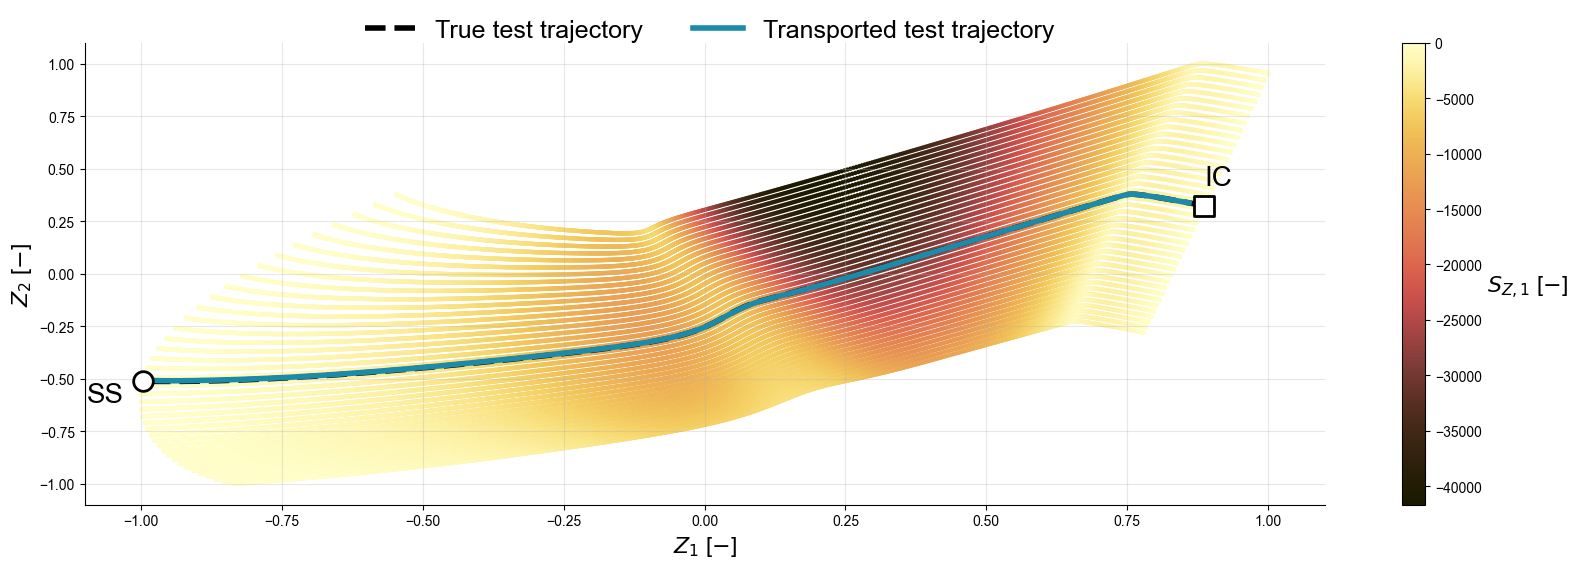

In [28]:
plt = reduction.plot_2d_manifold(X_QoIAwareProjection_CS[:,0], 
                                 X_QoIAwareProjection_CS[:,1], 
                                 color=S_QoIAwareProjection[:,0],
                                 color_map=cmap,
                                 x_label='$Z_1$ [$-$]',
                                 y_label='$Z_2$ [$-$]',
                                 colorbar_label='$S_{Z,1}$ [$-$]',
                                 figure_size=(20,6));

plt.plot(X_QoIAwareProjection_test_trajectory_CS[:,0], X_QoIAwareProjection_test_trajectory_CS[:,1], 'k--', zorder=1, lw=4, label='True test trajectory')
plt.plot(numerical_solution_dnn_model_CS[:,0], numerical_solution_dnn_model_CS[:,1], '-', color=color_dnn, lw=4, zorder=100, label='Transported test trajectory')

plt.scatter(X_QoIAwareProjection_test_trajectory_CS[0,0], X_QoIAwareProjection_test_trajectory_CS[0,1], c='w', edgecolors='k', marker='s', s=200, lw=2, zorder=100)
plt.scatter(X_QoIAwareProjection_test_trajectory_CS[-1,0], X_QoIAwareProjection_test_trajectory_CS[-1,1], c='w', edgecolors='k', marker='o', s=200, lw=2, zorder=100)
plt.text(X_QoIAwareProjection_test_trajectory_CS[0,0], X_QoIAwareProjection_test_trajectory_CS[0,1]+0.1, 'IC', fontsize=20)
plt.text(X_QoIAwareProjection_test_trajectory_CS[-1,0]-0.1, X_QoIAwareProjection_test_trajectory_CS[-1,1]-0.1, 'SS', fontsize=20)

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.legend(fontsize=18, frameon=False, markerscale=3, ncol=2, bbox_to_anchor=(0.8,1.1))

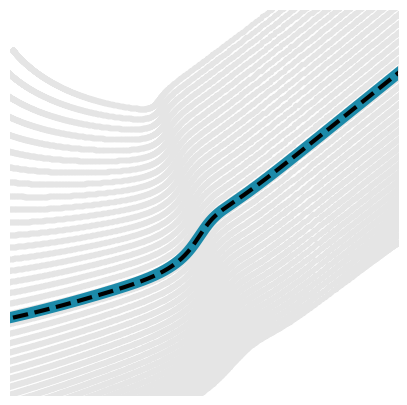

In [29]:
figure = plt.figure(figsize=(5,5))
spec = figure.add_gridspec(ncols=1, nrows=1, width_ratios=[1], height_ratios=[1])

scatter_size = 8

figure_c = figure.add_subplot(spec[0,0])
plt.scatter(X_QoIAwareProjection_CS[:,0], X_QoIAwareProjection_CS[:,1], c='#e5e5e5', s=scatter_size, zorder=10)
plt.plot(X_QoIAwareProjection_test_trajectory_CS[:,0], X_QoIAwareProjection_test_trajectory_CS[:,1], 'k--', lw=3, zorder=100)
plt.plot(numerical_solution_dnn_model_CS[:,0], numerical_solution_dnn_model_CS[:,1], '-', color=color_dnn, lw=8, zorder=30)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
plt.xticks([])
plt.yticks([])
plt.axis('equal')
plt.xlim([-0.5,0.6])
plt.ylim([-0.7, 0.5])
plt.savefig(plot_save_location + 'QoIAwareProjection-ROM.svg', dpi=400, bbox_inches='tight')

<a id='reconstruct-state-space'></a>

***

## Reconstruct the thermo-chemical state-space variables

[Go to the top ↑](#top-page)

#### Build a separate deep neural network (DNN) model for predicting the state variables:

In [30]:
state_space_CS, state_space_centers, state_space_scales = preprocess.center_scale(state_space, scaling='0to1')

In [31]:
dnn_model_state_space = ANN(X_QoIAwareProjection_CS,
                            state_space_CS,
                            interior_architecture=(5,10,10,10),
                            activation_functions=('tanh', 'tanh', 'tanh', 'sigmoid', 'sigmoid'),
                            weights_init='glorot_uniform',
                            biases_init='zeros',
                            loss='MSE',
                            optimizer='Adam',
                            batch_size=100,
                            n_epochs=1000,
                            learning_rate=0.001,
                            validation_perc=10,
                            random_seed=100,
                            verbose=True)

In [32]:
dnn_model_state_space.train()

Starting model training...


Using 10% of input data as validation data. Model will be trained on 90% of input data.



  0%|                                                  | 0/1000 [00:00<?, ?it/s]/Users/kamilazdybal/anaconda3/envs/latest-stack/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
100%|███████████████████████████████████████| 1000/1000 [08:10<00:00,  2.04it/s]

Time it took: 8.2 minutes.



<module 'matplotlib.pyplot' from '/Users/kamilazdybal/anaconda3/envs/latest-stack/lib/python3.10/site-packages/matplotlib/pyplot.py'>

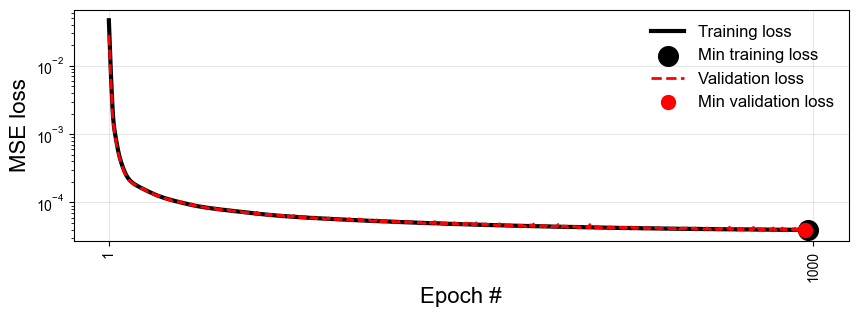

In [33]:
dnn_model_state_space.plot_losses(markevery=1000, figure_size=(10,3))

In [34]:
state_space_predicted = dnn_model_state_space.predict(X_QoIAwareProjection_CS)
state_space_predicted = preprocess.invert_center_scale(state_space_predicted, state_space_centers, state_space_scales)

/Users/kamilazdybal/anaconda3/envs/latest-stack/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [35]:
ann_metrics = reconstruction.RegressionAssessment(state_space, state_space_predicted, variable_names=list(state_space_names))
ann_metrics.print_metrics(table_format=['pandas'], float_format='.8f', metrics=['R2', 'NRMSE'])

,R2,NRMSE
T,0.99976888,0.01520263
H2,0.99968534,0.01773880
O2,0.99948309,0.02273561
O,0.99931900,0.02609588
OH,0.99954760,0.02126976
H2O,0.99968547,0.01773507
H,0.99948992,0.02258493
HO2,0.99944964,0.02345980
CO,0.99892991,0.03271217
CO2,0.99980154,0.01408747


<a id='visualize-reconstruction'></a>

***

## Visualize the predicted $H_2O$ mass fraction profile

[Go to the top ↑](#top-page)

In [36]:
state_space_ROM_predicted_dnn = dnn_model_state_space.predict(numerical_solution_dnn_model_CS)
state_space_ROM_predicted_dnn = preprocess.invert_center_scale(state_space_ROM_predicted_dnn, state_space_centers, state_space_scales)

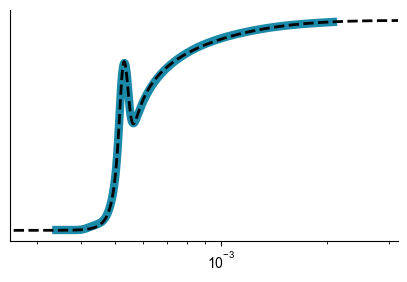

In [39]:
figure = plt.figure(figsize=(5, 3))
spec = figure.add_gridspec(ncols=1, nrows=1, width_ratios=[1], height_ratios=[1])
i = 5
figure_a = figure.add_subplot(spec[0,0])
plt.semilogx(time_grid_test_trajectory, state_space_test_trajectory[:,i], 'k--', lw=2, alpha=1, zorder=10, label='True test trajectory')
plt.semilogx(t_coordinates, state_space_ROM_predicted_dnn[:,i], c=color_dnn, lw=6, zorder=4, label='DNN closure model')
plt.xlim([10**-3.6,10**-2.5])
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.yticks([])
plt.xlabel('Time [s]', fontsize=16)
plt.ylabel('H$_2$O profile [$-$]', fontsize=16)
plt.savefig(plot_save_location + 'H2O-good-ROM.svg', dpi=400, bbox_inches='tight')

***